In [1]:
!pip3 install --quiet "tensorflow>=1.7"
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet seaborn

You are using pip version 19.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Semantic Similarity with TF-Hub Universal Encoder - Large

In [3]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

In [ ]:
# Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embeddings = session.run(embed(messages))

    for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
        print("Message: {}".format(messages[i]))
        print("Embedding size: {}".format(len(message_embedding)))
        message_embedding_snippet = ", ".join(
            (str(x) for x in message_embedding[:3]))
        print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

In [67]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")


def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
    message_embeddings_ = session_.run(encoding_tensor, feed_dict={input_tensor_: messages_})
    plot_similarity(messages_, message_embeddings_, 90)

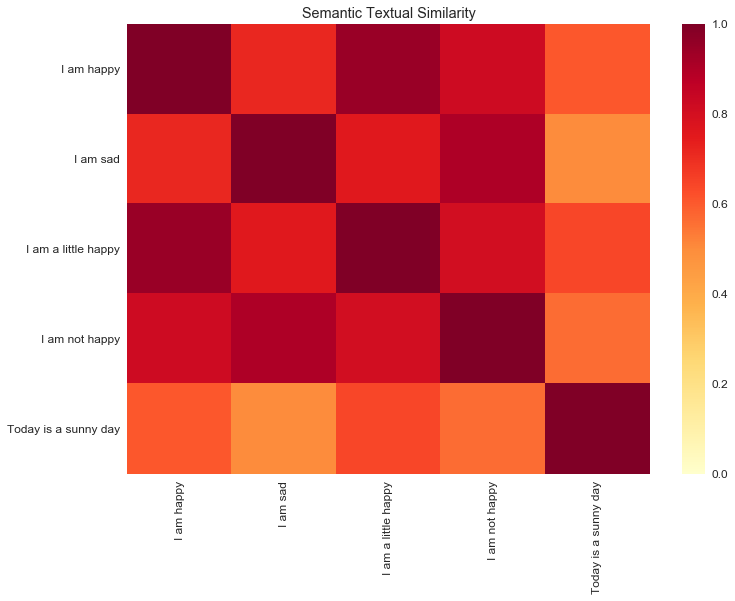

In [68]:
messages = [
    # Smartphones
#     "I like my phone",
#     "My phone is not good.",
#     "Your cellphone looks great.",

#     # Weather
#     "Will it snow tomorrow?",
#     "Recently a lot of hurricanes have hit the US",
#     "Global warming is real",

#     # Food and health
#     "An apple a day, keeps the doctors away",
#     "Eating strawberries is healthy",
#     "Is paleo better than keto?",

#     # Asking about age
#     "How old are you?",
#     "what is your age?",
#     "I like dogs",
#     "I like cats",
#     "I don't like dogs",
#     "I dislike dogs",
#     "Cats don't bark",
#     "Dogs bark",
    "I am happy",
    "I am sad",
    "I am a little happy",
    "I am not happy",
    "Today is a sunny day"
]

similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    run_and_plot(session, similarity_input_placeholder, messages,
               similarity_message_encodings)

## Evaluation: STS (Semantic Textual Similarity) Benchmark

In [8]:
import pandas
import scipy
import math


def load_sts_dataset(filename):
  # Loads a subset of the STS dataset into a DataFrame. In particular both
  # sentences and their human rated similarity score.
    sent_pairs = []
    with tf.gfile.GFile(filename, "r") as f:
        for line in f:
            ts = line.strip().split("\t")
          # (sent_1, sent_2, similarity_score)
            sent_pairs.append((ts[5], ts[6], float(ts[4])))
    return pandas.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])


def download_and_load_sts_data():
    sts_dataset = tf.keras.utils.get_file(
      fname="Stsbenchmark.tar.gz",
      origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
      extract=True)

    sts_dev = load_sts_dataset(
      os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"))
    sts_test = load_sts_dataset(
      os.path.join(
          os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"))

    return sts_dev, sts_test


sts_dev, sts_test = download_and_load_sts_data()

417792/409630 [==============================] - 1s 2us/step


In [9]:
sts_input1 = tf.placeholder(tf.string, shape=(None))
sts_input2 = tf.placeholder(tf.string, shape=(None))

# For evaluation we use exactly normalized rather than
# approximately normalized.
sts_encode1 = tf.nn.l2_normalize(embed(sts_input1), axis=1)
sts_encode2 = tf.nn.l2_normalize(embed(sts_input2), axis=1)
cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
sim_scores = 1.0 - tf.acos(clip_cosine_similarities)

In [10]:
sts_data = sts_dev #@param ["sts_dev", "sts_test"] {type:"raw"}

In [11]:
text_a = sts_data['sent_1'].tolist()
text_b = sts_data['sent_2'].tolist()
dev_scores = sts_data['sim'].tolist()

def run_sts_benchmark(session):
    """Returns the similarity scores"""
    emba, embb, scores = session.run(
      [sts_encode1, sts_encode2, sim_scores],
      feed_dict={
          sts_input1: text_a,
          sts_input2: text_b
      })
    return scores


with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    scores = run_sts_benchmark(session)

pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))

Pearson correlation coefficient = 0.7629205501666685
p-value = 4.521539751346317e-286


In [60]:
# example 1
raw1 = """"Unsalable Asset" means any Asset with respect to which the Collateral Manager certifies to the Trustee that (a) either (i) such Asset is (A) a Defaulted Obligation, (B) an Equity Security, (C) an obligation received in connection with an offer, in a restructuring or plan of reorganization with respect to the obligor, or (D) any other exchange or any other security or debt obligation that is part of the Assets, in the case of (A), (B) or (C) in respect of which the Issuer has not received a payment in cash during the preceding 12 months or (ii) such Asset has a Market Value of less than $10,000 and (b) the Collateral Manager has made commercially reasonable efforts to dispose of such Asset for at least 90 days and (y) in its commercially reasonable judgment such Asset is not expected to be saleable for the foreseeable future.
"""

# example 2
raw2 = """"Unsalable Asset" means any Asset with respect to which the Collateral Manager certifies to the Trustee that (a) either (i) such Asset is (A) a Defaulted Obligation, (B) an Equity Security, (C) an obligation received in connection with an offer, in a restructuring or plan of reorganization with respect to the obligor, or (D) any other exchange or any other security or debt obligation that is part of the Assets, in the case of (A), (B) or (C) in respect of which the Issuer has not received a payment in cash during the preceding 12 months or (ii) such Asset has a Market Value of less than $10,000 and (b) the Collateral Manager has made commercially reasonable efforts to dispose of such Asset for at least 90 days and (y) in its commercially reasonable judgment such Asset is not expected to be saleable for the foreseeable future.
"""

# example 1
raw3 = """"Adjusted Weighted Average Moody's Rating Factor": As of any date of determination, a number equal to the Weighted Average Moody's Rating Factor determined in the following manner": for purposes of determining a Moody's Default Probability Rating or Moody's Rating in connection with determining the Weighted Average Moody's Rating Factor for purposes of this definition, each applicable rating on credit watch by Moody's that is on (a) positive watch will be treated as having been upgraded by one rating subcategory, (b) negative watch will be treated as having been downgraded by two rating subcategories and (c) negative outlook will be treated as having been downgraded by one rating subcategory.
"""

# example 1
raw4 = """"Target Initial Par Condition" means a condition satisfied as of the Effective Date if the aggregate principal balance of Collateral Obligations that are held by the Issuer and that the Issuer has committed to purchase on such date, together with the amount of any proceeds of prepayments, maturities or redemptions of Collateral Obligations purchased by the Issuer prior to such date (other than any such proceeds that have been reinvested in Collateral Obligations held by the Issuer on the Effective Date), will equal or exceed the Target Initial Par Amount; provided that for purposes of this definition, any Collateral Obligation that becomes a Defaulted Obligation prior to the Effective Date shall be treated as having a principal balance equal to its Moody's Collateral Value.
"""

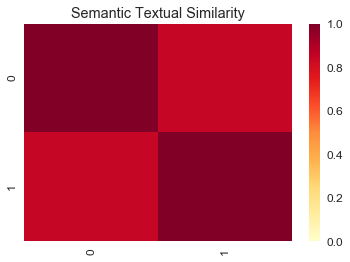

In [63]:
messages = [raw1, raw2]
similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    run_and_plot(session, similarity_input_placeholder, 
                 [str(i) for i in range(len(messages))], similarity_message_encodings)

## Universal Sentence Encoder-Lite demo

In [30]:
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub
# Install other packages.
!pip3 install --quiet seaborn
# Install SentencePiece package
# SentencePiece package is needed for Universal Sentence Encoder Lite. We'll
# use it for all the text processing and sentence feature ID lookup.
!pip3 install --quiet sentencepiece

You are using pip version 19.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.1, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [29]:
import tensorflow as tf
import tensorflow_hub as hub
import sentencepiece as spm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [31]:
module = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-lite/2")

In [32]:
input_placeholder = tf.sparse_placeholder(tf.int64, shape=[None, None])
encodings = module(
    inputs=dict(
        values=input_placeholder.values,
        indices=input_placeholder.indices,
        dense_shape=input_placeholder.dense_shape))

In [34]:
with tf.Session() as sess:
    spm_path = sess.run(module(signature="spm_path"))

sp = spm.SentencePieceProcessor()
sp.Load(spm_path)
print("SentencePiece model loaded at {}.".format(spm_path))

SentencePiece model loaded at b'/var/folders/df/jdb52f_x5vjcrdf9rqv8gbr00000gn/T/tfhub_modules/539544f0a997d91c327c23285ea00c37588d92cc/assets/universal_encoder_8k_spm.model'.


In [35]:
def process_to_IDs_in_sparse_format(sp, sentences):
    # An utility method that processes sentences with the sentence piece processor
    # 'sp' and returns the results in tf.SparseTensor-similar format:
    # (values, indices, dense_shape)
    ids = [sp.EncodeAsIds(x) for x in sentences]
    max_len = max(len(x) for x in ids)
    dense_shape=(len(ids), max_len)
    values=[item for sublist in ids for item in sublist]
    indices=[[row,col] for row in range(len(ids)) for col in range(len(ids[row]))]
    return (values, indices, dense_shape)

In [36]:
# Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

values, indices, dense_shape = process_to_IDs_in_sparse_format(sp, messages)

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embeddings = session.run(
      encodings,
      feed_dict={input_placeholder.values: values,
                input_placeholder.indices: indices,
                input_placeholder.dense_shape: dense_shape})

    for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
        print("Message: {}".format(messages[i]))
        print("Embedding size: {}".format(len(message_embedding)))
        message_embedding_snippet = ", ".join(
            (str(x) for x in message_embedding[:3]))
        print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [0.053387485444545746, 0.053194381296634674, -0.052356019616127014, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.035332899540662766, -0.047149740159511566, 0.012305582873523235, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [-0.004081785213202238, -0.08954869210720062, 0.03737204149365425, ...]



In [38]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")


def run_and_plot(session, input_placeholder, messages):
    values, indices, dense_shape = process_to_IDs_in_sparse_format(sp,messages)

    message_embeddings = session.run(
      encodings,
      feed_dict={input_placeholder.values: values,
                input_placeholder.indices: indices,
                input_placeholder.dense_shape: dense_shape})
  
    plot_similarity(messages, message_embeddings, 90)

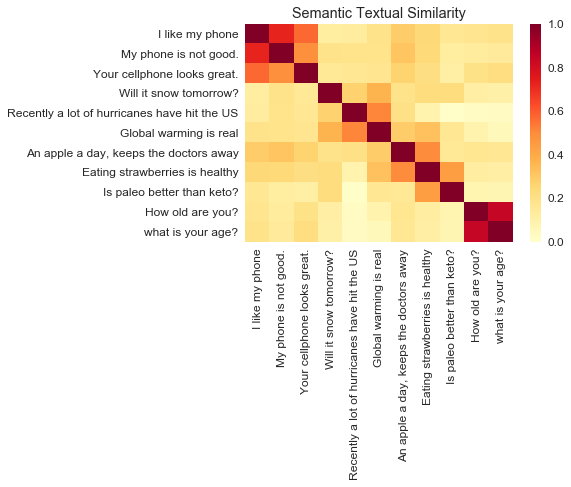

In [39]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]


with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    run_and_plot(session, input_placeholder, messages)

In [41]:
import pandas
import scipy
import math


def load_sts_dataset(filename):
  # Loads a subset of the STS dataset into a DataFrame. In particular both
  # sentences and their human rated similarity score.
    sent_pairs = []
    with tf.gfile.GFile(filename, "r") as f:
        for line in f:
            ts = line.strip().split("\t")
        # (sent_1, sent_2, similarity_score)
            sent_pairs.append((ts[5], ts[6], float(ts[4])))
    return pandas.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])


def download_and_load_sts_data():
    sts_dataset = tf.keras.utils.get_file(
      fname="Stsbenchmark.tar.gz",
      origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
      extract=True)

    sts_dev = load_sts_dataset(
      os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"))
    sts_test = load_sts_dataset(
      os.path.join(
          os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"))

    return sts_dev, sts_test


sts_dev, sts_test = download_and_load_sts_data()

In [42]:
sts_input1 = tf.sparse_placeholder(tf.int64, shape=(None, None))
sts_input2 = tf.sparse_placeholder(tf.int64, shape=(None, None))

# For evaluation we use exactly normalized rather than
# approximately normalized.
sts_encode1 = tf.nn.l2_normalize(
    module(
        inputs=dict(values=sts_input1.values,
                    indices=sts_input1.indices,
                    dense_shape=sts_input1.dense_shape)),
    axis=1)
sts_encode2 = tf.nn.l2_normalize(
    module(
        inputs=dict(values=sts_input2.values,
                    indices=sts_input2.indices,
                    dense_shape=sts_input2.dense_shape)),
    axis=1)

sim_scores = -tf.acos(tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1))



In [48]:
def run_sts_benchmark(session):
    """Returns the similarity scores"""
    emba, embb, scores = session.run(
      [sts_encode1, sts_encode2, sim_scores],
      feed_dict={
          sts_input1: text_a,
          sts_input2: text_b
      })
    return scores


with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    scores = run_sts_benchmark(session)

pearson_correlation = scipy.stats.pearsonr(scores, similarity_scores)
print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))

ValueError: invalid literal for int() with base 10: 'A man with a hard hat is dancing.'

In [47]:
sts_data = sts_test #@param ["sts_dev", "sts_test"] {type:"raw"}